# 🎯 Objective
Audio Classification is the task of analysing and assigning a label to an audio recording. It is used for tasks such as speech recognition, music genre classification, and detecting environmental sounds. The objective of this notebook is to build a model which is capable of classifying audio recordings of sounds in urban areas.

# 📁 Dataset
The dataset used in this notebook is the UrbanSound8K dataset. This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, children_playing, dog_bark, drilling, enginge_idling, gun_shot, jackhammer, siren, and street_music. The classes are drawn from the urban sound taxonomy and the files are pre-sorted into ten folds (folders named fold1-fold10) to help in the reproduction of and comparison with the automatic classification results reported in the associated dataset paper.

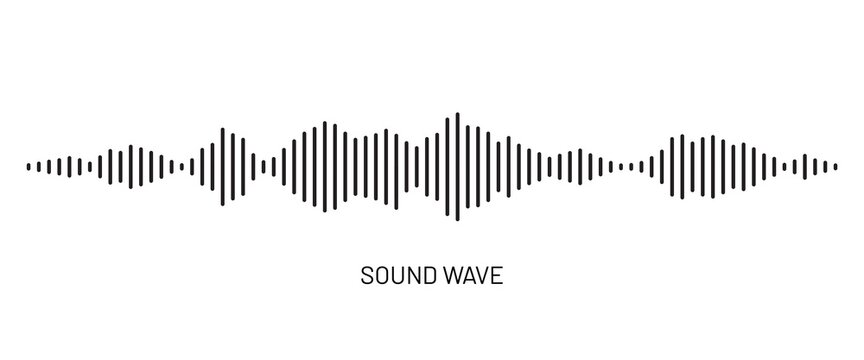

# Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
import IPython.display as ipd
import librosa
import librosa.display

In [3]:
filename = '/kaggle/input/urbansound8k/fold5/190893-2-0-11.wav'

# **Librosa**

In [4]:
librosa_audio_data,librosa_sample_rate = librosa.load(filename)

In [5]:
librosa_audio_data

array([-0.00180967, -0.01352534, -0.03195794, ..., -0.00540592,
       -0.00450171,  0.00347472], dtype=float32)

In [6]:
librosa_sample_rate

22050

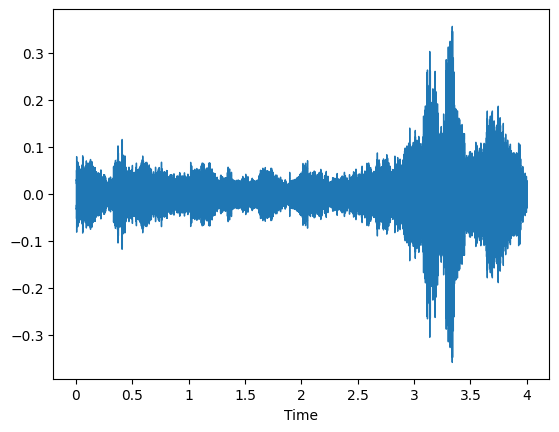

In [7]:
librosa.display.waveshow(librosa_audio_data,sr=librosa_sample_rate)
ipd.Audio(filename)

### Here Librosa converts the signal to mono, meaning the channel will alays be 1

# **scipy**

In [8]:
from scipy.io import wavfile as wav
wave_sample_rate,wave_audio = wav.read(filename)

In [9]:
wave_audio

array([[ -29,  -65],
       [-106, -321],
       [-178, -698],
       ...,
       [-317,  127],
       [-150,  355],
       [  48,  583]], dtype=int16)

In [10]:
wave_sample_rate

44100

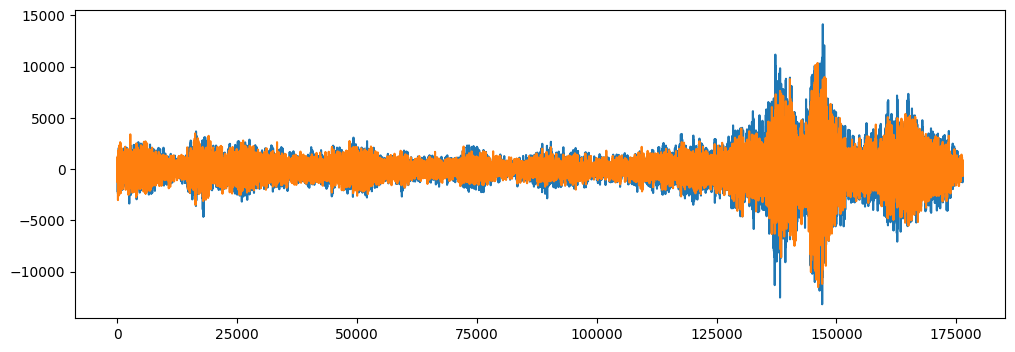

In [11]:
plt.figure(figsize=(12,4))
plt.plot(wave_audio)
plt.show()

### Here Scipy converts the signal to stereo, meaning the channels will be 2

# **Metadata**

In [12]:
metadata = pd.read_csv('../input/urbansound8k/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [13]:
metadata.shape

(8732, 8)

In [14]:
metadata.isnull().sum()

slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64

In [15]:
metadata.duplicated().sum()

0

In [16]:
#check whether the dataset is balanced/imbalanced
metadata['class'].value_counts()

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

### The data is balanced

# Data Visualization

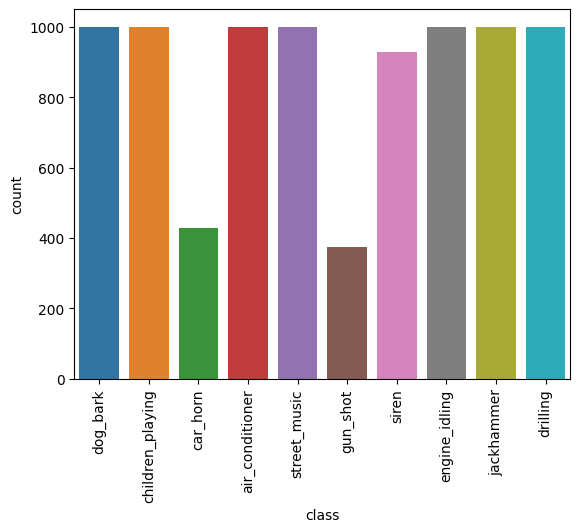

In [17]:
sns.countplot(x='class',data=metadata)
plt.xticks(rotation=90)
plt.show()

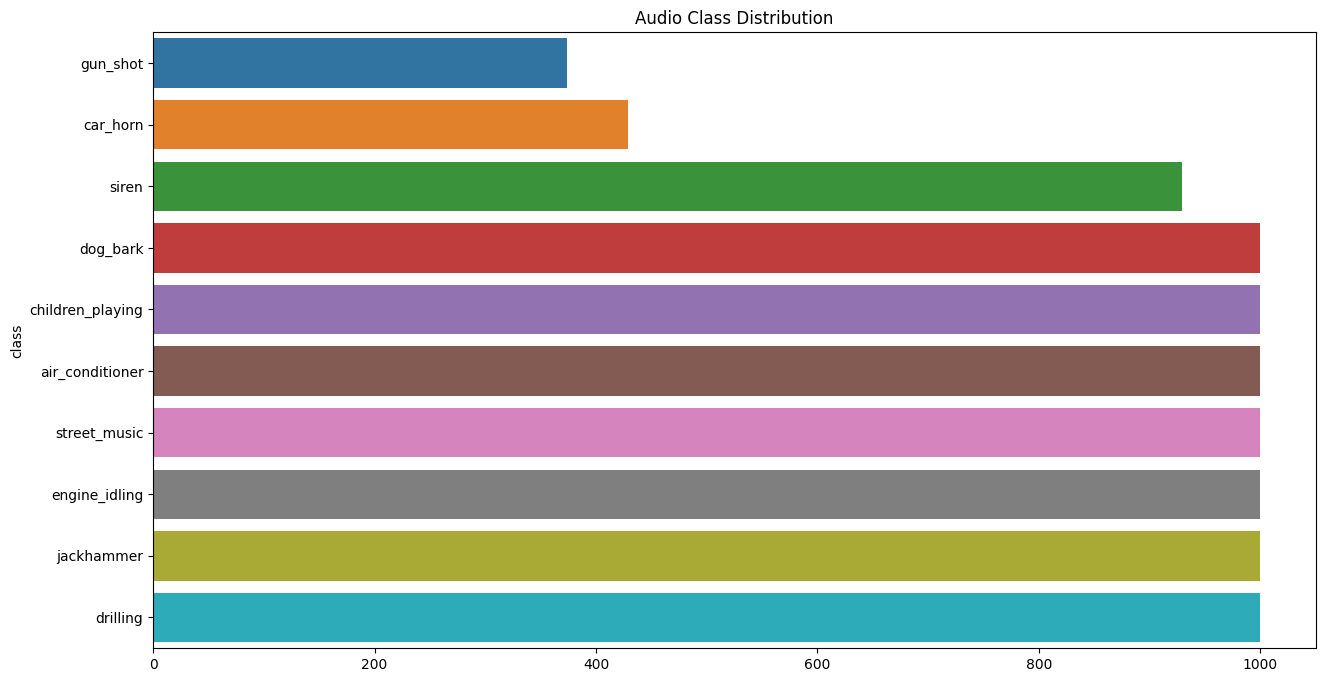

In [18]:
plt.figure(figsize=(15,8))
plt.title('Audio Class Distribution')
class_dist = metadata['class'].value_counts().sort_values()
sns.barplot(x=class_dist.values,
           y=class_dist.keys())
plt.show()

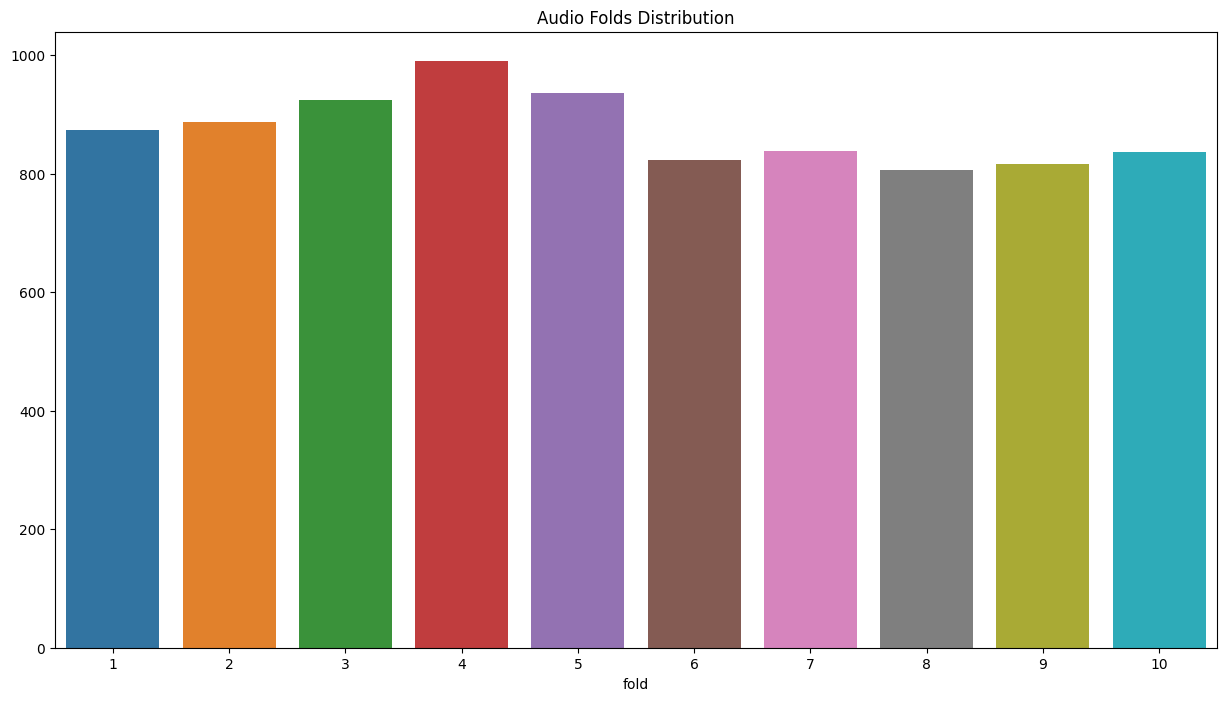

In [19]:
plt.figure(figsize=(15,8))
plt.title('Audio Folds Distribution')
folds_dist = metadata['fold'].value_counts().sort_values()
sns.barplot(y=folds_dist.values,
           x=folds_dist.keys())
plt.show()

# Data Preprocessing

## Feature Extraction

*  Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio samples. 
*  The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. 
*  These audio representations will allow us to identify features for classification.

In [20]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=50)
mfccs

array([[-250.7297   , -218.86018  , -203.31895  , ..., -220.58412  ,
        -234.88823  , -269.432    ],
       [  86.098236 ,   79.87907  ,   81.53845  , ...,  113.62471  ,
         112.33217  ,  104.04004  ],
       [ -49.641876 ,  -44.56617  ,  -42.068504 , ...,  -37.475483 ,
         -26.1459   ,  -16.622765 ],
       ...,
       [  -7.952583 ,   -7.009885 ,   -0.272533 , ...,   11.134179 ,
           5.0520496,    1.7420273],
       [ -10.854353 ,   -9.791126 ,   -7.3976197, ...,    2.8609872,
          -1.0604756,    0.6414124],
       [   4.6877246,    3.41859  ,   -2.1935441, ...,    5.7797794,
           2.212251 ,    4.8804083]], dtype=float32)

In [21]:
mfccs.shape

(50, 173)

### This is the preprocessing for a single individual file.

In [22]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name) 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=50)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features

In [23]:
audio_dataset_path='../input/urbansound8k/'

In [24]:
import os
from tqdm import tqdm

In [25]:
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for i,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

8732it [11:46, 12.36it/s]


In [26]:
#converting extracted features to pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-211.93698, 62.581215, -122.813156, -60.74529...",dog_bark
1,"[-417.0052, 99.336624, -42.995583, 51.073326, ...",children_playing
2,"[-452.39316, 112.36253, -37.57807, 43.195866, ...",children_playing
3,"[-406.47922, 91.1966, -25.043556, 42.78452, 11...",children_playing
4,"[-439.63873, 103.86223, -42.658787, 50.690285,...",children_playing


# Data Splitting

In [27]:
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['class'].tolist())

In [28]:
X

array([[-2.11936981e+02,  6.25812149e+01, -1.22813156e+02, ...,
         1.23093772e+00, -5.30414248e+00,  2.22271156e+00],
       [-4.17005188e+02,  9.93366241e+01, -4.29955826e+01, ...,
         1.16269362e+00, -1.96495378e+00,  4.15635735e-01],
       [-4.52393158e+02,  1.12362534e+02, -3.75780716e+01, ...,
         6.01064444e-01, -2.65929937e+00,  7.46222198e-01],
       ...,
       [-2.97315338e+02,  1.02090256e+02, -3.67510796e+01, ...,
         2.20239782e+00,  1.95113897e+00, -3.40595126e-01],
       [-3.36923859e+02,  1.15313904e+02, -4.48470917e+01, ...,
         3.53287309e-01, -1.25762677e+00, -1.70473552e+00],
       [-3.07417633e+02,  8.33067245e+01, -2.57565117e+01, ...,
         4.89573479e+00, -4.30078888e+00, -7.42102957e+00]], dtype=float32)

In [29]:
X.shape

(8732, 50)

In [30]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [31]:
y.shape

(8732,)

# Categorical Encoding

In [32]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

# Train Test Split

In [33]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=42)

In [34]:
X_train.shape

(7422, 50)

In [35]:
X_test.shape

(1310, 50)

In [36]:
y_train.shape

(7422, 10)

In [37]:
y_test.shape

(1310, 10)

In [38]:
print("Number of training samples = ", X_train.shape[0])
print("Number of testing samples = ",X_test.shape[0])

Number of training samples =  7422
Number of testing samples =  1310


# Model Building

In [39]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix,classification_report

In [41]:
#No of classes
num_labels = y.shape[1]
num_labels

10

In [42]:
model = Sequential()
# first layer
model.add(Dense(256,input_shape=(50,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# second layer
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
#third layer
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(128))

#final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               13056     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               6

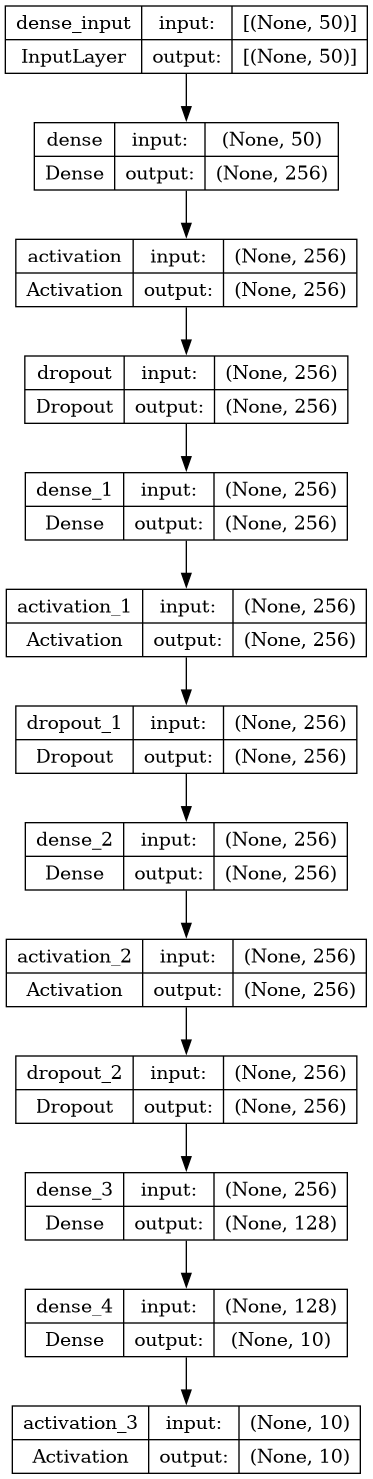

In [44]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [45]:
model.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    optimizer='adam')

# Model Training

In [46]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 150
num_batch_size = 32

In [47]:
training = model.fit(X_train,
                     y_train,
                     batch_size=num_batch_size,
                     epochs=num_epochs,
                    validation_data=(X_test,y_test))

Epoch 1/150
232/232 [==============================] - 3s 6ms/step - loss: 7.4992 - accuracy: 0.1521 - val_loss: 2.1609 - val_accuracy: 0.2351
Epoch 2/150
232/232 [==============================] - 1s 5ms/step - loss: 2.3001 - accuracy: 0.1994 - val_loss: 2.1108 - val_accuracy: 0.1977
Epoch 3/150
232/232 [==============================] - 1s 4ms/step - loss: 2.0891 - accuracy: 0.2567 - val_loss: 1.9414 - val_accuracy: 0.2328
Epoch 4/150
232/232 [==============================] - 1s 4ms/step - loss: 1.9382 - accuracy: 0.3009 - val_loss: 1.7698 - val_accuracy: 0.3634
Epoch 5/150
232/232 [==============================] - 1s 4ms/step - loss: 1.8162 - accuracy: 0.3514 - val_loss: 1.6484 - val_accuracy: 0.4214
Epoch 6/150
232/232 [==============================] - 1s 4ms/step - loss: 1.6798 - accuracy: 0.4078 - val_loss: 1.5339 - val_accuracy: 0.4794
Epoch 7/150
232/232 [==============================] - 1s 5ms/step - loss: 1.6011 - accuracy: 0.4446 - val_loss: 1.4174 - val_accuracy: 0.5458

In [48]:
test_accuracy = model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.8923664093017578


In [49]:
train_hist = pd.DataFrame(training.history)
train_hist

,loss,accuracy,val_loss,val_accuracy
0,7.499227,0.152115,2.160938,0.235114
1,2.300124,0.199407,2.110804,0.197710
2,2.089107,0.256669,1.941442,0.232824
3,1.938221,0.300862,1.769762,0.363359
4,1.816191,0.351388,1.648428,0.421374
...,...,...,...,...
145,0.451327,0.860415,0.396950,0.895420
146,0.443590,0.857855,0.395261,0.889313
147,0.476702,0.850984,0.392182,0.894656
148,0.456132,0.856912,0.401951,0.880153


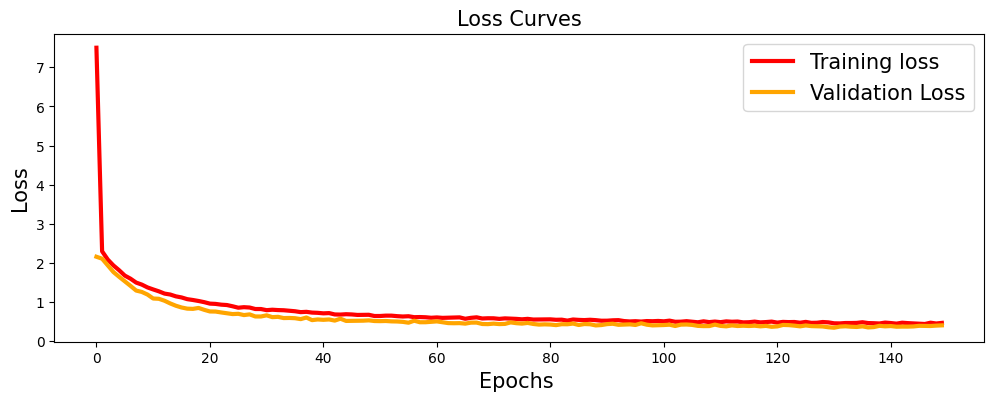

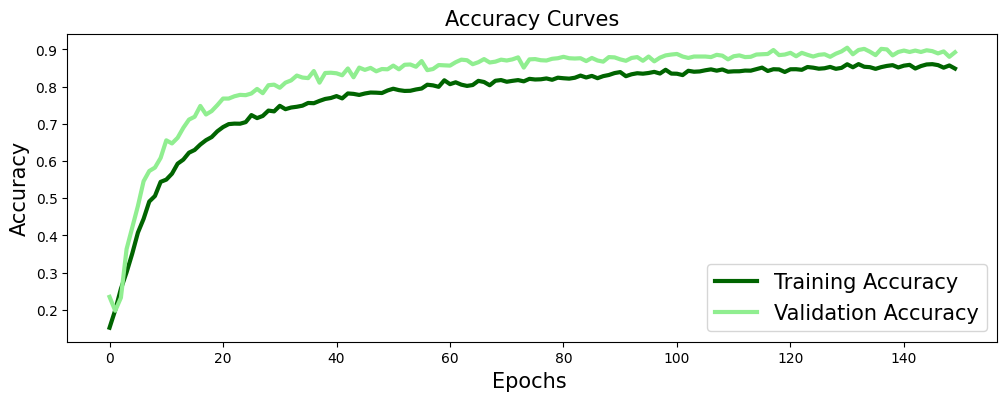

In [50]:
# Loss curves
plt.figure(figsize=[12,4])
plt.plot(training.history['loss'],'red',linewidth=3.0)
plt.plot(training.history['val_loss'],'orange',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=15)
plt.xlabel('Epochs ',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title('Loss Curves',fontsize=15)


# Accuracy Curves
plt.figure(figsize=[12,4])
plt.plot(training.history['accuracy'],'darkgreen',linewidth=3.0)
plt.plot(training.history['val_accuracy'],'lightgreen',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=15)
plt.xlabel('Epochs ',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.title('Accuracy Curves',fontsize=15)
plt.show()

In [51]:
ytrue = np.argmax(y_test,axis=1)
ypred = np.argmax(model.predict(X_test),axis=1)

41/41 [==============================] - 0s 2ms/step


In [52]:
from sklearn.metrics import confusion_matrix, classification_report
print('\nConfusion Matrix :\n\n')
print(confusion_matrix(ytrue,ypred))


Confusion Matrix :


[[140   0   8   0   0   4   0   0   1   6]
 [  0  55   2   2   0   1   0   0   1   3]
 [  1   0 134   3   0   0   1   0   3   5]
 [  3   0  12 126   2   0   0   0   1   2]
 [  0   0   6   2 134   0   1   4   0   8]
 [  1   0   4   0   0 137   0   0   0   1]
 [  0   0   2   6   1   0  38   0   1   1]
 [  1   0   0   0   1   0   0 148   0   1]
 [  0   0   2   5   0   0   0   0 117   0]
 [  2   0  18   5   3   3   0   0   1 140]]


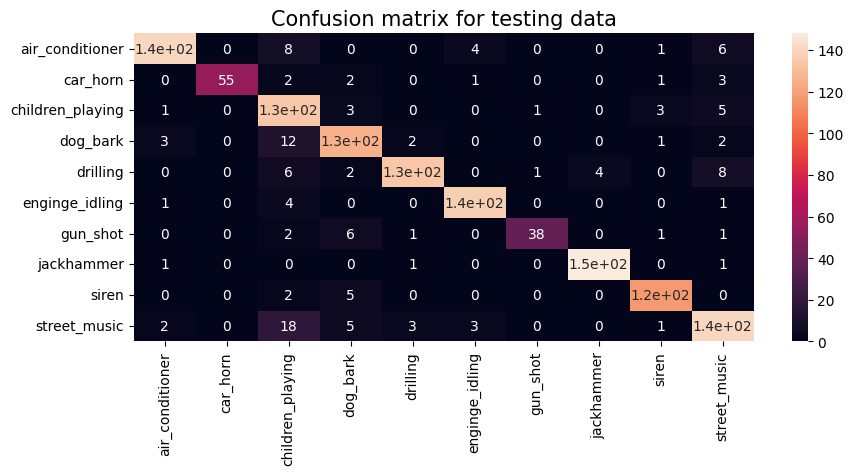

In [53]:
plt.figure(figsize=(10,4))
plt.title("Confusion matrix for testing data", fontsize = 15)
plt.xlabel("Predicted class")
plt.ylabel("True class")
sns.heatmap(confusion_matrix(ytrue,ypred),annot=True,
           xticklabels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'enginge_idling', 'gun_shot', 'jackhammer', 'siren','street_music'],
           yticklabels=['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'enginge_idling', 'gun_shot', 'jackhammer', 'siren','street_music'])

plt.show()

In [54]:
print('\n\nClassification Report : \n\n',classification_report(ytrue,ypred))



Classification Report : 

               precision    recall  f1-score   support

           0       0.95      0.88      0.91       159
           1       1.00      0.86      0.92        64
           2       0.71      0.91      0.80       147
           3       0.85      0.86      0.85       146
           4       0.95      0.86      0.91       155
           5       0.94      0.96      0.95       143
           6       0.95      0.78      0.85        49
           7       0.97      0.98      0.98       151
           8       0.94      0.94      0.94       124
           9       0.84      0.81      0.83       172

    accuracy                           0.89      1310
   macro avg       0.91      0.89      0.89      1310
weighted avg       0.90      0.89      0.89      1310



# Model Prediction

In [55]:
X_test[1]

array([-8.02253437e+00,  1.12755035e+02, -1.81556683e+01,  2.84234829e+01,
       -1.27770786e+01,  6.17681980e+00, -1.18947344e+01,  7.11439180e+00,
       -8.16670036e+00, -3.77119780e+00, -9.78234577e+00, -6.23640156e+00,
       -9.94229698e+00, -5.95497727e-01, -5.51220751e+00, -1.58082604e+00,
       -6.52468920e+00, -2.72377133e+00, -7.19589949e+00, -4.14205647e+00,
       -4.13311434e+00,  4.09037447e+00, -3.42284441e+00, -2.24278879e+00,
       -7.60056829e+00, -2.73272109e+00, -4.65861702e+00, -5.32068789e-01,
       -5.65531158e+00,  2.36052155e+00,  6.71531391e+00,  8.74744320e+00,
        1.12496614e-01,  1.08901501e+00, -3.02489185e+00, -2.23138499e+00,
       -6.67724323e+00,  1.83605361e+00,  6.97077572e-01,  7.63069987e-01,
       -3.75846457e+00,  2.07468963e+00, -7.11396933e-02, -9.65634808e-02,
       -3.35032177e+00,  7.30996251e-01, -1.88804507e+00,  2.61091614e+00,
       -8.73576343e-01, -1.57231498e+00], dtype=float32)

In [56]:
filename = '/kaggle/input/urbansound8k/fold5/190893-2-0-11.wav'
prediction_feature = features_extractor(filename)
prediction_feature = prediction_feature.reshape(1,-1)
np.argmax(model.predict(prediction_feature),axis=1)

1/1 [==============================] - 0s 37ms/step


array([1])

In [57]:
prediction_feature.shape

(1, 50)

In [58]:
np.argmax(model.predict(X_test),axis=1)

41/41 [==============================] - 0s 2ms/step


array([8, 9, 4, ..., 0, 9, 0])

# Testing Some Test Audio Data

In [59]:
filename = "/kaggle/input/urbansound8k/fold8/103076-3-0-0.wav"
audio,sample_rate = librosa.load(filename)
mfccs_features = librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=50)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

In [60]:
mfccs_scaled_features

array([-4.3579456e+02,  5.7867905e+01, -3.1872950e+00, -1.9904032e+01,
       -2.0641861e+01, -2.2496643e+01, -1.9619402e+01, -1.1440505e+01,
       -9.8861065e+00,  4.3746200e-01,  3.6107092e+00,  1.3495115e+00,
        1.5682597e+00,  3.3248966e+00,  5.3259511e+00,  1.6191688e+00,
       -3.5303676e+00, -3.6765375e+00, -6.3732424e+00, -8.6413736e+00,
       -8.3451672e+00, -4.6818123e+00, -2.0709708e+00,  2.4145410e+00,
        1.8110491e+00, -1.0843935e-01, -3.1374383e+00, -3.4383001e+00,
       -4.1745191e+00, -3.9663985e+00, -3.1244624e+00,  5.3930330e-01,
       -6.3234025e-01,  1.0686821e+00,  1.1267076e+00,  2.1163018e+00,
        1.3684055e+00,  7.9674959e-01,  2.0303573e-01, -7.3811394e-01,
       -1.7383384e+00, -1.2268116e+00, -8.8372684e-01,  1.3248426e-01,
        3.6340025e-01,  1.6926574e+00,  1.9031420e+00,  2.2184961e+00,
        1.7511542e+00,  2.6375325e+00], dtype=float32)

In [61]:
mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
mfccs_scaled_features

array([[-4.3579456e+02,  5.7867905e+01, -3.1872950e+00, -1.9904032e+01,
        -2.0641861e+01, -2.2496643e+01, -1.9619402e+01, -1.1440505e+01,
        -9.8861065e+00,  4.3746200e-01,  3.6107092e+00,  1.3495115e+00,
         1.5682597e+00,  3.3248966e+00,  5.3259511e+00,  1.6191688e+00,
        -3.5303676e+00, -3.6765375e+00, -6.3732424e+00, -8.6413736e+00,
        -8.3451672e+00, -4.6818123e+00, -2.0709708e+00,  2.4145410e+00,
         1.8110491e+00, -1.0843935e-01, -3.1374383e+00, -3.4383001e+00,
        -4.1745191e+00, -3.9663985e+00, -3.1244624e+00,  5.3930330e-01,
        -6.3234025e-01,  1.0686821e+00,  1.1267076e+00,  2.1163018e+00,
         1.3684055e+00,  7.9674959e-01,  2.0303573e-01, -7.3811394e-01,
        -1.7383384e+00, -1.2268116e+00, -8.8372684e-01,  1.3248426e-01,
         3.6340025e-01,  1.6926574e+00,  1.9031420e+00,  2.2184961e+00,
         1.7511542e+00,  2.6375325e+00]], dtype=float32)

In [62]:
mfccs_scaled_features.shape

(1, 50)

In [63]:
predicted_label = np.argmax(model.predict(mfccs_scaled_features),axis=1)
predicted_label

1/1 [==============================] - 0s 22ms/step


array([3])

In [64]:
prediction_class = labelencoder.inverse_transform(predicted_label)
prediction_class

array(['dog_bark'], dtype='<U16')

In [65]:
ipd.Audio(filename)

# Predictions

In [66]:
def predict(filename):
    audio, sample_rate = librosa.load(filename) 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=50)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
    predicted_label = np.argmax(model.predict(mfccs_scaled_features),axis=1)
    prediction_class = labelencoder.inverse_transform(predicted_label)
    print(prediction_class)
    return ipd.Audio(filename)

In [67]:
predict('/kaggle/input/urbansound8k/fold8/103076-3-0-0.wav')

1/1 [==============================] - 0s 41ms/step
['dog_bark']


In [68]:
predict('/kaggle/input/urbansound8k/fold10/102857-5-0-16.wav')

1/1 [==============================] - 0s 42ms/step
['engine_idling']


In [69]:
predict('/kaggle/input/urbansound8k/fold3/103199-4-2-0.wav')

1/1 [==============================] - 0s 41ms/step
['drilling']


In [70]:
import pickle
# create an iterator object with write permission - model.pkl
with open('sound.pkl', 'wb') as f:
    pickle.dump(model, f)

f.close()

In [ ]:
import joblib
joblib.dump(labelencoder, 'labelencoder.joblib')